## Fourier Shell Correlation
Measures the normalised cross-correlation coefficient between 2 3D volumes over shells in Fourier Space.

$$FSC(r) = \frac{\sum_{r_i \in r} F_1(r_i) \cdot F_2(r_i)^*}{\sqrt{\sum_{r_i \in r} |F_1(r_i)|^2 \cdot \sum_{r_i \in r} |F_2(r_i)|^2}}$$


I have used the implementation here (https://github.com/teamtomo/torch-fourier-shell-correlation/blob/main/src/torch_fourier_shell_correlation/fsc.py) as a guide, which uses the fftfreq_grid function found here (https://github.com/teamtomo/torch-grid-utils/blob/main/src/torch_grid_utils/fftfreq_grid.py). I chose this because it seemed smarter and more vectorized than my first attempt would have been. 


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


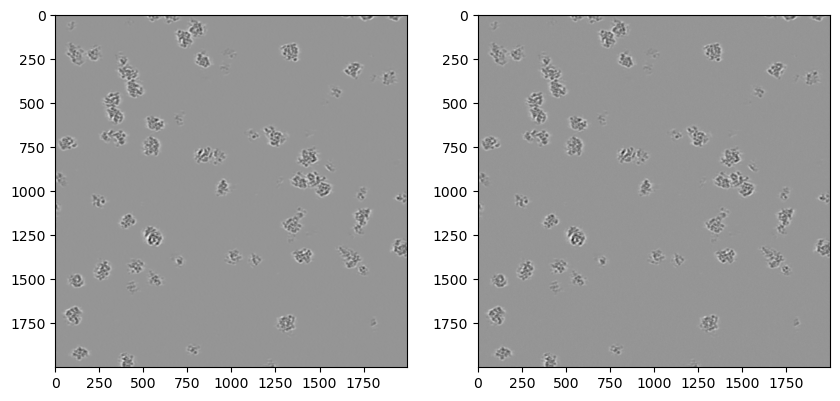

In [1]:
import torch, mrcfile, numpy as np
import matplotlib.pyplot as plt

denoised_image = mrcfile.read('/Users/HenryJones/Desktop/SULI/cryocare_denoised.mrc')
denoised_tensor = torch.tensor(denoised_image)
mean = torch.zeros_like(denoised_tensor)
std = torch.ones_like(denoised_tensor) * 10

noisy_image = torch.normal(mean = mean, std = std)
del(mean, std, denoised_image)
noisy_image = noisy_image + denoised_tensor

fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].imshow(denoised_tensor[100,:,:].numpy(), cmap = 'Greys_r')
ax[1].imshow(noisy_image[100,:,:].numpy(), cmap = 'Greys_r')

## Full FFT

In [ ]:
def make_ffreq_radius(tensor1_shape: torch.Tensor):
    """
    Makes an array marking the Euclidian distance from the center (because we did fftshift) of the fourier domain
    """

    meshgrid = torch.meshgrid([torch.arange(tensor1_shape[0]) - tensor1_shape[0]/2,
                                                    torch.arange(tensor1_shape[1]) - tensor1_shape[1]/2,
                                                    torch.arange(tensor1_shape[2]) - tensor1_shape[2]/2],
                                                    indexing = 'ij')
    freq_radius = torch.sqrt(torch.pow(meshgrid[0],2) + torch.pow(meshgrid[1],2) + torch.pow(meshgrid[2],2))
    del(meshgrid)
    return freq_radius

def _normalised_cc_complex_1d(a: torch.Tensor, b:torch.Tensor):
    correlation = torch.dot(a, torch.conj(b))
    return correlation / (torch.linalg.norm(a) * torch.linalg.norm(b))


def compute_ffsc(tensor1: torch.Tensor, tensor2: torch.Tensor):
    tensor1 = torch.fft.fftshift(torch.fft.fftn(tensor1), dim = (-3, -2, -1))
    tensor2 = torch.fft.fftshift(torch.fft.fftn(tensor2), dim = (-3, -2, -1))
    assert tensor1.shape == tensor2.shape
    max_dist = torch.sqrt(torch.tensor((tensor1.shape[0]/2)**2 + (tensor1.shape[1]/2)**2 + (tensor1.shape[2]/2)**2))
    bin_interval = 10
    bins = torch.arange(0, max_dist + bin_interval, bin_interval)
    freq_radius = make_ffreq_radius(tensor1.shape)
    sorted_frequencies_flat, sort_idx_flat = torch.sort(torch.flatten(freq_radius), descending = False)
    split_idx = torch.searchsorted(sorted_frequencies_flat, bins) #split points are bins
    del(sorted_frequencies_flat, bins)
    shell_index = torch.tensor_split(sort_idx_flat, split_idx)[:-1] #if we don't exlude the last one, we just shape of 144?
    del(sort_idx_flat, split_idx)
    tensor1 = torch.flatten(tensor1)
    tensor2 = torch.flatten(tensor2)
    fsc = torch.real(torch.tensor([
    _normalised_cc_complex_1d(tensor1[idx], tensor2[idx])
    for idx in shell_index
    ]))
    return fsc
    

full_fsc = compute_ffsc(noisy_image, denoised_tensor)

Text(0.5, 1.0, 'FSC')

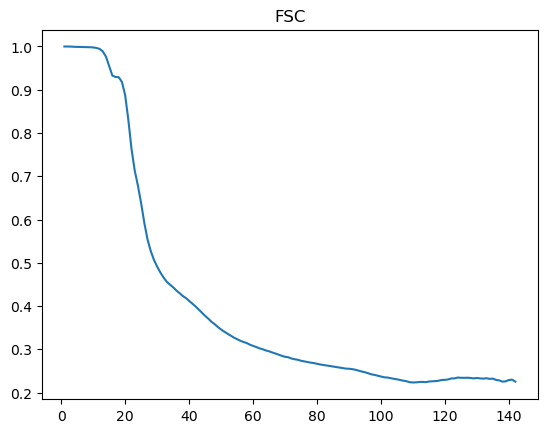

In [3]:
plt.plot(torch.arange(full_fsc.shape[0]), full_fsc.numpy())
plt.title("FSC")

## RFFT
make the datasetup

In [3]:
def make_rfreq_radius(tensor1_shape: torch.Tensor):
    print(tensor1_shape)
    meshgrid = torch.meshgrid([torch.arange(tensor1_shape[0])  - tensor1_shape[0]/2,
                                torch.arange(tensor1_shape[1]) - tensor1_shape[1]/2,
                                torch.arange(tensor1_shape[2]).float()], #don't adjust the last one, because we did rfft
                                indexing = 'ij')
    freq_radius = torch.sqrt(torch.pow(meshgrid[0],2) + torch.pow(meshgrid[1],2) + torch.pow(meshgrid[2],2))
    del(meshgrid)
    return freq_radius

def _normalised_cc_real_1d(tensor1: torch.Tensor, tensor2:torch.Tensor):
    #correlation = torch.dot(tensor1, torch.conj(tensor2))
    if tensor1.shape[0] == 0:
        return 0
    else:
        correlation = torch.nn.functional.conv1d(tensor1.unsqueeze(0).unsqueeze(0), tensor2.unsqueeze(0).unsqueeze(0))
        return correlation / (torch.linalg.norm(tensor1) * torch.linalg.norm(tensor2))


def compute_rfsc(tensor1: torch.Tensor, tensor2: torch.Tensor):
    tensor1 = torch.fft.rfftn(tensor1)
    tensor2 = torch.fft.rfftn(tensor2)

    assert tensor1.shape == tensor2.shape
    freq_radius = make_rfreq_radius(tensor1.shape)
    print(freq_radius[99:102, 999:1001, :2])
    sorted_frequencies_flat, sort_idx_flat = torch.sort(torch.flatten(freq_radius), descending = False)
    del(freq_radius)

    bin_interval = 10
    max_dist = torch.sqrt(torch.tensor((tensor1.shape[0]/2)**2 + (tensor1.shape[1]/2)**2 + (tensor1.shape[2])**2))
    print(max_dist)
    bins = torch.arange(0, max_dist + bin_interval, bin_interval)
    split_idx = torch.searchsorted(sorted_frequencies_flat, bins)
    #del(sorted_frequencies_flat)
    shell_index = torch.tensor_split(sort_idx_flat, split_idx)[:-1] #exlude last one because of binning
    print(len(shell_index), 'shell shape')
    #del(sort_idx_flat)

    for idx in shell_index[:5]:
        print(idx.shape)

    tensor1 = torch.flatten(tensor1)
    tensor2 = torch.flatten(tensor2)
    fsc = torch.real(torch.tensor([
    _normalised_cc_real_1d(tensor1[idx], tensor2[idx])
    for idx in shell_index
    ]))   

    return fsc

In [4]:
fsc = compute_rfsc(noisy_image, denoised_tensor)

torch.Size([200, 2000, 1001])
tensor([[[1.4142, 1.7321],
         [1.0000, 1.4142]],

        [[1.0000, 1.4142],
         [0.0000, 1.0000]],

        [[1.4142, 1.7321],
         [1.0000, 1.4142]]])
tensor(1418.4502)
143 shell shape
torch.Size([0])
torch.Size([2222])
torch.Size([15086])
torch.Size([40562])
torch.Size([78502])


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Text(0.5, 1.0, 'FSC')

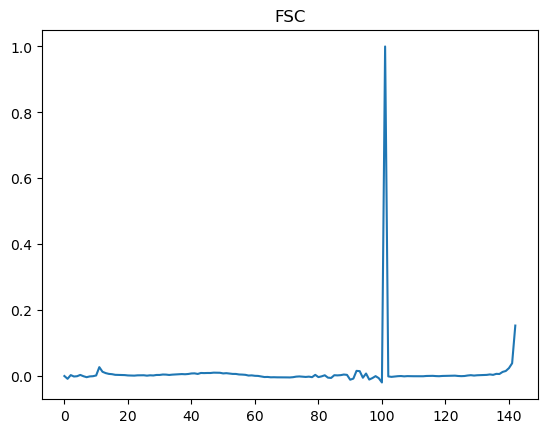

In [7]:
plt.plot(np.arange(143), fsc.numpy())
plt.title("FSC")

In [19]:
print(noisy_image.shape)
shape = torch.fft.rfft(noisy_image).shape
print(shape)
z, y, x = shape #row major order
freq_z = torch.fft.fftfreq(z)
freq_y = torch.fft.fftfreq(y)
freq_x = torch.fft.fftfreq(x)
print(freq_x.shape, freq_y.shape, freq_z.shape)
print(torch.max(freq_z), torch.min(freq_z))
print(torch.max(freq_x), torch.min(freq_x))
print(freq_x[:5], freq_y[:5], freq_z[:5])
import einops
freq_zz = einops.repeat(freq_z, 'd -> d h w', h=y, w=x)
freq_yy = einops.repeat(freq_y, 'h -> d h w', d=y, w=x)
freq_xx = einops.repeat(freq_x, 'w -> d h w', d=y, h=x)
print(freq_zz.shape, freq_yy.shape, freq_xx.shape)
this = einops.rearrange([freq_zz, freq_yy, freq_xx], 'freq ... -> ... freq')
freq_zz.shape

torch.Size([200, 2000, 2000])
torch.Size([200, 2000, 1001])
torch.Size([1001]) torch.Size([2000]) torch.Size([200])
tensor(0.4950) tensor(-0.5000)
tensor(0.4995) tensor(-0.4995)
tensor([0.0000, 0.0010, 0.0020, 0.0030, 0.0040]) tensor([0.0000, 0.0005, 0.0010, 0.0015, 0.0020]) tensor([0.0000, 0.0050, 0.0100, 0.0150, 0.0200])
torch.Size([200, 2000, 1001]) torch.Size([2000, 2000, 1001]) torch.Size([2000, 1001, 1001])


RuntimeError: stack expects each tensor to be equal size, but got [200, 2000, 1001] at entry 0 and [2000, 2000, 1001] at entry 1

### 2D Ring testing

In [53]:
def make_ffreq_radius(tensor1_shape: torch.Tensor):
    meshgrid = torch.meshgrid([torch.arange(tensor1_shape[0]) - tensor1_shape[0]/2,
                            torch.arange(tensor1_shape[1]) - tensor1_shape[1]/2,],
                                                    indexing = 'ij')
    freq_radius = torch.sqrt(torch.pow(meshgrid[0],2) + torch.pow(meshgrid[1],2))
    del(meshgrid)
    return freq_radius

def _normalised_cc_complex_1d(a: torch.Tensor, b:torch.Tensor):
    correlation = torch.dot(a, torch.conj(b))
    return correlation / (torch.linalg.norm(a) * torch.linalg.norm(b))


def compute_ffsc(tensor1: torch.Tensor, tensor2: torch.Tensor):
    tensor1 = torch.fft.fftshift(torch.fft.fft2(tensor1)) #, #dim = (-2, -1))       #These don't seem to do anything 
    tensor2 = torch.fft.fftshift(torch.fft.fft2(tensor2)) #, dim = (-2, -1))        #super noticeable at least in 2d
    assert tensor1.shape == tensor2.shape
    max_dist = torch.sqrt(torch.tensor((tensor1.shape[0]/2)**2 + (tensor1.shape[1]/2)**2))
    bin_interval = 10
    bins = torch.arange(0, max_dist + bin_interval, bin_interval)
    freq_radius = make_ffreq_radius(tensor1.shape)
    sorted_frequencies_flat, sort_idx_flat = torch.sort(torch.flatten(freq_radius), descending = False)
    split_idx = torch.searchsorted(sorted_frequencies_flat, bins) #split points are bins
    del(sorted_frequencies_flat, bins)
    shell_index = torch.tensor_split(sort_idx_flat, split_idx)[:-1] #if we don't exlude the last one, we just shape of 144?
    del(sort_idx_flat, split_idx)
    tensor1 = torch.flatten(tensor1)
    tensor2 = torch.flatten(tensor2)
    fsc = torch.real(torch.tensor([
    _normalised_cc_complex_1d(tensor1[idx], tensor2[idx])
    for idx in shell_index
    ]))
    return fsc
    
full_fsc_2d = compute_ffsc(noisy_image[100,:,:], denoised_tensor[100,:,:])

Text(0.5, 1.0, 'FSC')

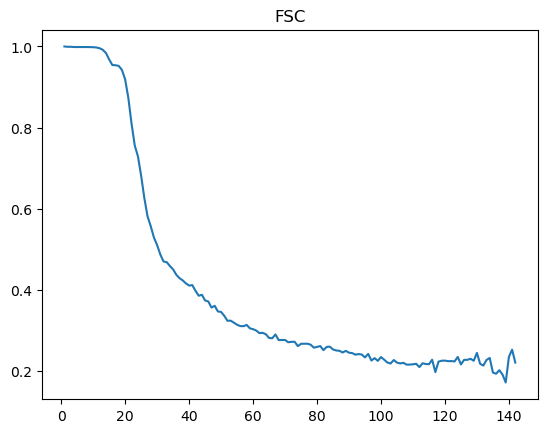

In [54]:
plt.plot(torch.arange(full_fsc_2d.shape[0]), full_fsc_2d.numpy())
plt.title("FSC")

### 2D RFFT

In [55]:
def make_rfreq_radius(tensor1_shape: torch.Tensor):
    print(tensor1_shape)
    meshgrid = torch.meshgrid([torch.arange(tensor1_shape[0])  - tensor1_shape[0]/2,
                                torch.arange(tensor1_shape[1]).float()], #don't adjust the last one, because we did rfft
                                indexing = 'ij')
    freq_radius = torch.sqrt(torch.pow(meshgrid[0],2) + torch.pow(meshgrid[1],2))
    del(meshgrid)
    return freq_radius

def _normalised_cc_real_1d(tensor1: torch.Tensor, tensor2:torch.Tensor):
    #correlation = torch.dot(tensor1, torch.conj(tensor2))
    correlation = torch.dot(tensor1, torch.conj(tensor2))
    return correlation / (torch.linalg.norm(tensor1) * torch.linalg.norm(tensor2))


def compute_rfsc(tensor1: torch.Tensor, tensor2: torch.Tensor):
    tensor1 = torch.fft.rfft2(tensor1)
    tensor2 = torch.fft.rfft2(tensor2)

    assert tensor1.shape == tensor2.shape
    freq_radius = make_rfreq_radius(tensor1.shape)
    sorted_frequencies_flat, sort_idx_flat = torch.sort(torch.flatten(freq_radius), descending = False)
    del(freq_radius)

    bin_interval = 10
    max_dist = torch.sqrt(torch.tensor((tensor1.shape[0]/2)**2 + (tensor1.shape[1])**2))
    print(max_dist)
    bins = torch.arange(0, max_dist + bin_interval, bin_interval)
    split_idx = torch.searchsorted(sorted_frequencies_flat, bins)
    #del(sorted_frequencies_flat)
    shell_index = torch.tensor_split(sort_idx_flat, split_idx)[:-1] #exlude last one because of binning
    print(len(shell_index), 'shell shape')
    #del(sort_idx_flat)

    for idx in shell_index[:5]:
        print(idx.shape)

    tensor1 = torch.flatten(tensor1)
    tensor2 = torch.flatten(tensor2)
    fsc = torch.real(torch.tensor([
    _normalised_cc_real_1d(tensor1[idx], tensor2[idx])
    for idx in shell_index
    ]))   

    return fsc

torch.Size([2000, 1001])
tensor(1414.9209)
143 shell shape
torch.Size([0])
torch.Size([162])
torch.Size([480])
torch.Size([792])
torch.Size([1112])


Text(0.5, 1.0, 'FSC')

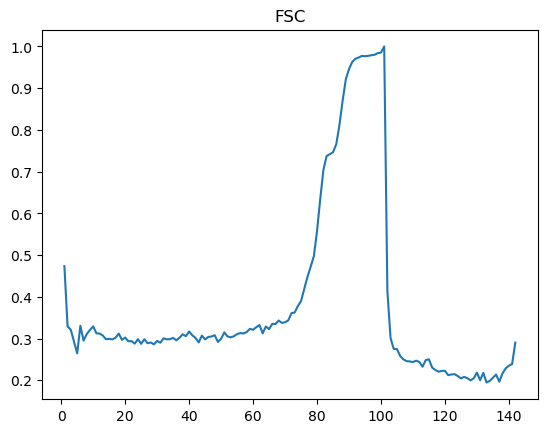

In [58]:
fsc_r_rd = compute_rfsc(noisy_image[100,:,:], denoised_tensor[100,:,:])
plt.plot(torch.arange(fsc_r_rd.shape[0]), fsc_r_rd.numpy())
plt.title("FSC")

## fftfreq the horizontal axis?
Doesn't seem right

torch.Size([2000, 1001])
tensor(1414.9209)
143 shell shape
torch.Size([0])
torch.Size([162])
torch.Size([480])
torch.Size([792])
torch.Size([1112])


Text(0.5, 1.0, 'FSC')

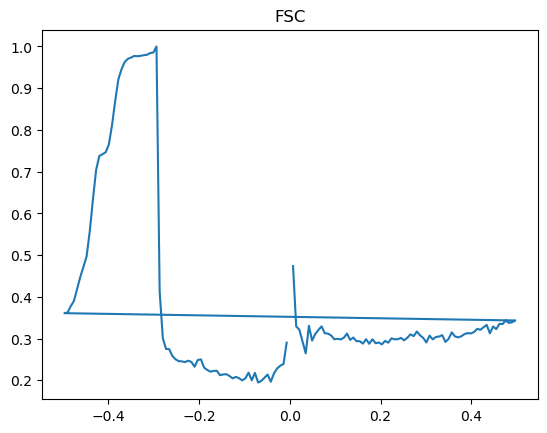

In [60]:
fsc_r_rd = compute_rfsc(noisy_image[100,:,:], denoised_tensor[100,:,:])
plt.plot(torch.fft.fftfreq(fsc_r_rd.shape[0]), fsc_r_rd.numpy())
plt.title("FSC")

## 1d trials

In [61]:
x = np.linspace(0, 4 * (np.pi **2), num = 101)
print(np.shape(x))
empty = np.zeros_like(x)
for i in range(1,10):
    empty+= (1/i)*(np.cos((x*i)/(2*np.pi))) + (1/(i**2))*(np.sin((x*i)/(2*np.pi)))
values = empty
print(values[:5])

(101,)
[2.82896825 2.91735193 2.83518708 2.61566781 2.3125571 ]


In [62]:
time_domain = torch.tensor(values)

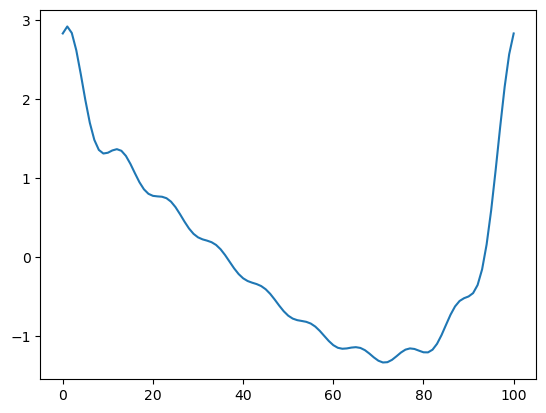

In [63]:
plt.plot(np.arange(len(values)), values)

## Just the data

/Users/HenryJones/miniconda3/envs/envupdate/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/HenryJones/miniconda3/envs/envupdate/lib/python3.11/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/HenryJones/miniconda3/envs/envupdate/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<StemContainer object of 3 artists>

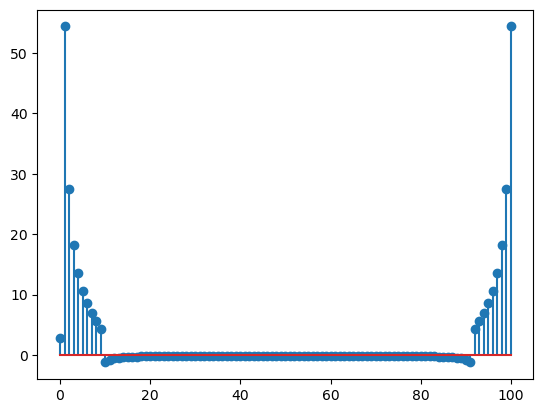

In [64]:
plt.stem(np.arange(len(values)), torch.fft.fft(time_domain).numpy())

## WIth fftfreq

<StemContainer object of 3 artists>

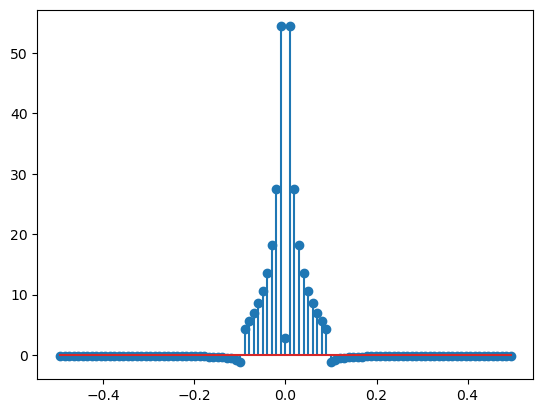

In [65]:
plt.stem(torch.fft.fftfreq(time_domain.shape[0]).numpy(), torch.fft.fft(time_domain).numpy())

## fftshift instead of fftfreq

<StemContainer object of 3 artists>

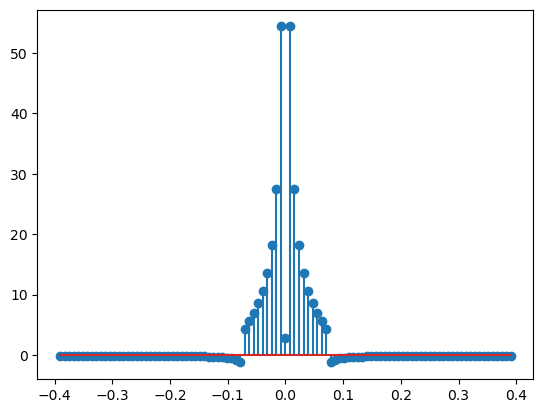

In [51]:
plt.stem(np.linspace(-(4*(np.pi **2)/101), 4*(np.pi **2)/101, 101),torch.fft.fftshift(torch.fft.fft(time_domain)).numpy())

/Users/HenryJones/miniconda3/envs/envupdate/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/HenryJones/miniconda3/envs/envupdate/lib/python3.11/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/HenryJones/miniconda3/envs/envupdate/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<StemContainer object of 3 artists>

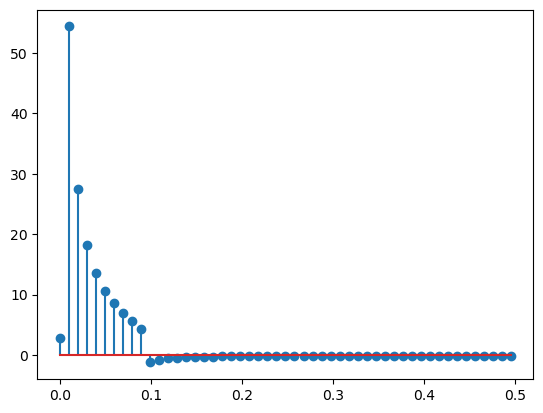

In [34]:
plt.stem(torch.fft.rfftfreq(time_domain.shape[0]).numpy(), torch.fft.rfft(time_domain).numpy())

/Users/HenryJones/miniconda3/envs/envupdate/lib/python3.11/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/HenryJones/miniconda3/envs/envupdate/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<StemContainer object of 3 artists>

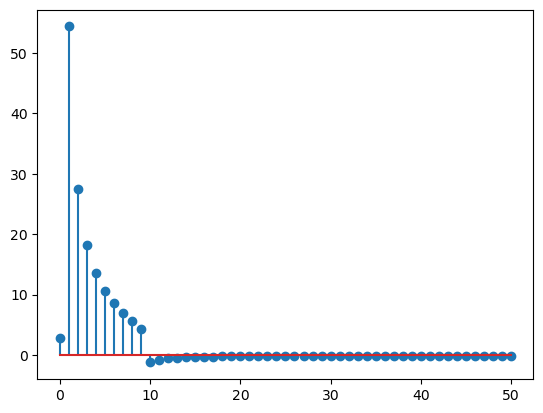

In [38]:
plt.stem(np.arange(time_domain.shape[0]/2), torch.fft.rfft(time_domain).numpy())

In [39]:
print(torch.fft.fftfreq(len(time_domain)))

tensor([ 0.0000,  0.0099,  0.0198,  0.0297,  0.0396,  0.0495,  0.0594,  0.0693,
         0.0792,  0.0891,  0.0990,  0.1089,  0.1188,  0.1287,  0.1386,  0.1485,
         0.1584,  0.1683,  0.1782,  0.1881,  0.1980,  0.2079,  0.2178,  0.2277,
         0.2376,  0.2475,  0.2574,  0.2673,  0.2772,  0.2871,  0.2970,  0.3069,
         0.3168,  0.3267,  0.3366,  0.3465,  0.3564,  0.3663,  0.3762,  0.3861,
         0.3960,  0.4059,  0.4158,  0.4257,  0.4356,  0.4455,  0.4554,  0.4653,
         0.4752,  0.4851,  0.4950, -0.4950, -0.4851, -0.4752, -0.4653, -0.4554,
        -0.4455, -0.4356, -0.4257, -0.4158, -0.4059, -0.3960, -0.3861, -0.3762,
        -0.3663, -0.3564, -0.3465, -0.3366, -0.3267, -0.3168, -0.3069, -0.2970,
        -0.2871, -0.2772, -0.2673, -0.2574, -0.2475, -0.2376, -0.2277, -0.2178,
        -0.2079, -0.1980, -0.1881, -0.1782, -0.1683, -0.1584, -0.1485, -0.1386,
        -0.1287, -0.1188, -0.1089, -0.0990, -0.0891, -0.0792, -0.0693, -0.0594,
        -0.0495, -0.0396, -0.0297, -0.01

In [40]:
print(torch.fft.rfftfreq(len(time_domain)))

tensor([0.0000, 0.0099, 0.0198, 0.0297, 0.0396, 0.0495, 0.0594, 0.0693, 0.0792,
        0.0891, 0.0990, 0.1089, 0.1188, 0.1287, 0.1386, 0.1485, 0.1584, 0.1683,
        0.1782, 0.1881, 0.1980, 0.2079, 0.2178, 0.2277, 0.2376, 0.2475, 0.2574,
        0.2673, 0.2772, 0.2871, 0.2970, 0.3069, 0.3168, 0.3267, 0.3366, 0.3465,
        0.3564, 0.3663, 0.3762, 0.3861, 0.3960, 0.4059, 0.4158, 0.4257, 0.4356,
        0.4455, 0.4554, 0.4653, 0.4752, 0.4851, 0.4950])
